In [1]:
import numpy as np
import torch.nn as nn
from utils import get_dataloaders
train_boston, test_boston = get_dataloaders('boston', test_size=0.2, batch_size=100)
train_breast_cancer , test_breast_cancer = get_dataloaders('breast_cancer', test_size=0.2, batch_size=100)
train_diabetes , test_diabetes = get_dataloaders('diabetes', test_size=0.2, batch_size=100)
train_digits, test_digits = get_dataloaders('digits', test_size=0.2, batch_size=100)

In [2]:
import exp_s
from exp_s import  exp_activations, exp_FFN

### Общая информация

Работу выполнил Хисматуллин Владимир.

В данной работе исследуется зависимость распределения активация нейронной сети от гиперпараметров:

Глубина, ширина, skip-connect, Batch Norm, DropOut, инциализация, обрезание (clipping) активаций.

Графики не векторные, так как с ними могут быть лаги.

В отчёте почти нет кода - всё спрятано в модули exp_s (эксперименты) и utils (модель сети и вспомогательные функции).

### Пара слов про DataSet'ы
Все данные стандартизированы. Для регрессионных моделей стандартизированы отклики, таким образом отклики сетей для разных задач сравнивать корректно.

Информация о датасетах:

    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    << Name           |  Type     ||  Instances  ||  Features  >>
    <<--------------------------------------------------------->>
    << boston         |  REG      ||  506        ||  13        >>
    << breast_cancer  |  CLF, 2   ||  569        ||  30        >>
    << diabetes       |  REG      ||  442        ||  10        >>
    << digits         |  CLF, 10  ||  1797       ||  64        >>
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
Более подробно проанализируем их далее.

### Отметим, чего нам хотелось бы от распределения активаций:
1. Симметричности на линейном слое.
2. Малая дисперсия.
3. Сохранение распределения при продвижении вглубь.

### Эксперимент 1: функции активации

Вначале определимся с функцией активации, так как от неё зависит очень многое. Даже если она не входит в задание, не представляется возможным провести исследования без анализа зависимости распределений от неё.

Ниже для сети из 4 слоёв, все слои которой имеют ширину 40, на датасете boston проводится обучение модели, а далее снимаются активации на обучающей выборке. Также выводится качество предсказания на тестовой выборке.

Рассматриваются активации: ReLU, Tanh, Sigmoid, LeakyReLU, Hardshrink, GELU

ReLU Cross Entropy loss : 0.0027


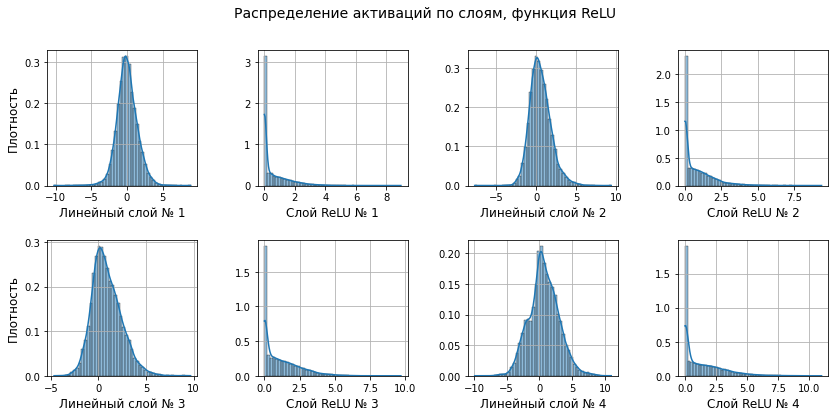

Tanh Cross Entropy loss : 0.0033


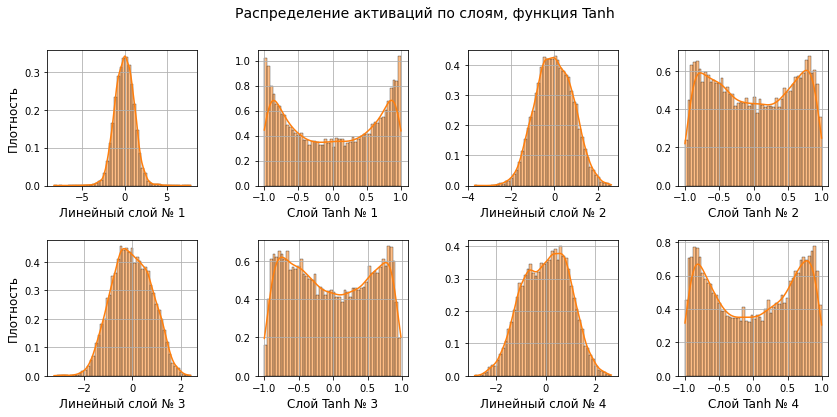

Sigmoid Cross Entropy loss : 0.0249


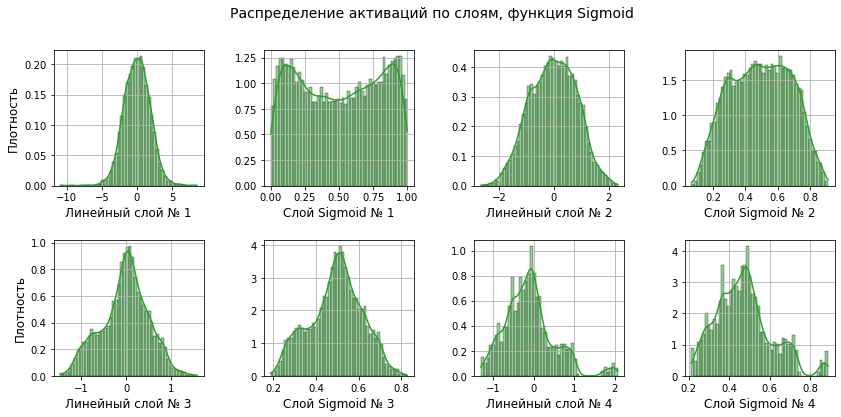

nn.LeakyReLU Cross Entropy loss : 0.0030


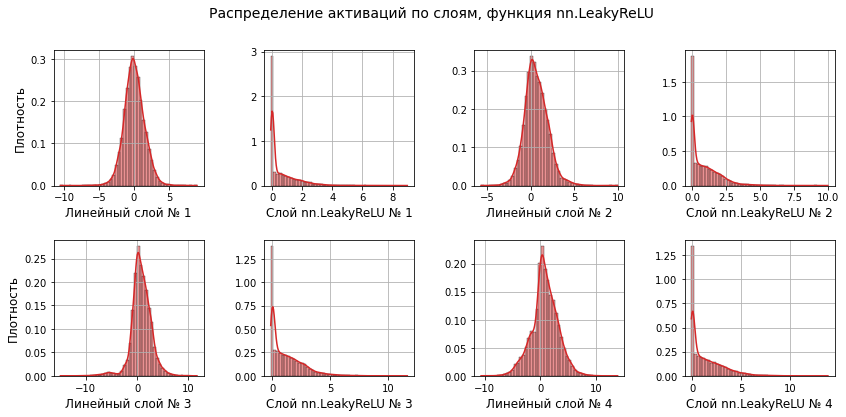

Hardshrink Cross Entropy loss : 0.0032


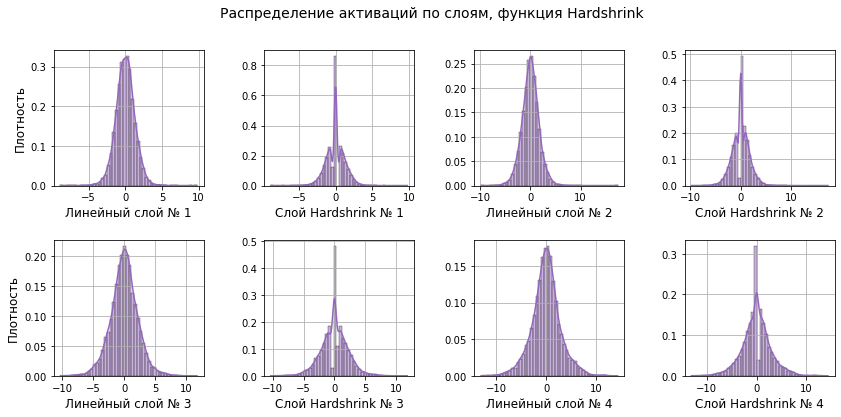

GELU Cross Entropy loss : 0.0025


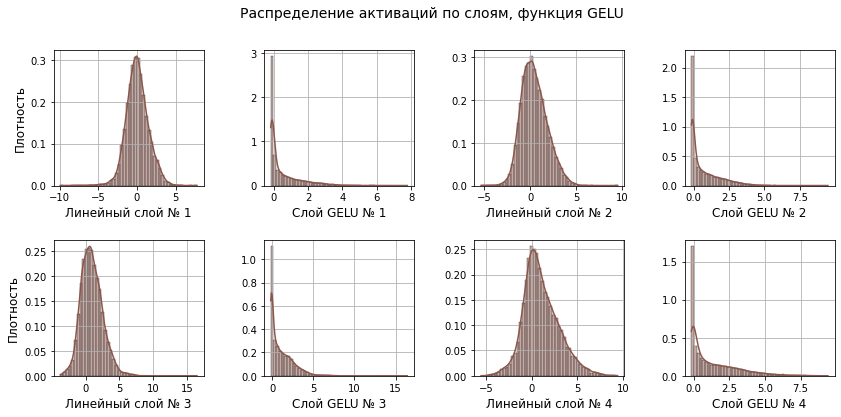

In [3]:
activation_list = [nn.ReLU(), nn.Tanh(), nn.Sigmoid(), nn.LeakyReLU(), nn.Hardshrink(), nn.GELU()]
act_name_list = ['ReLU', 'Tanh', 'Sigmoid', 'nn.LeakyReLU', 'Hardshrink', 'GELU']
title_list = ['Распределение активаций по слоям, функция ' + act for act in act_name_list]
color = ['C' + str(i) for i in range(6)]
for i in range(6):
    exp_activations(train_digits, test_digits, activation_list[i], act_name_list[i], title_list[i], color[i], n_classes=10)

На данных графиках, очевидно, побеждает GELU:

1. Tanh и Sigmoid нарушили симметричность, не сохранили распределение и повысили дисперсию.

2. ReLU, Hardshrink более-менее сохранили вид распределения, но увеличили дисперсию.

4. GELU и LeakyReLU сохранили дисперсию, однако для GELU она чуть ниже.

Повторим процедуру для трёх лучших функций  на датасете классификации digits

nn.LeakyReLU Cross Entropy loss : 0.0025


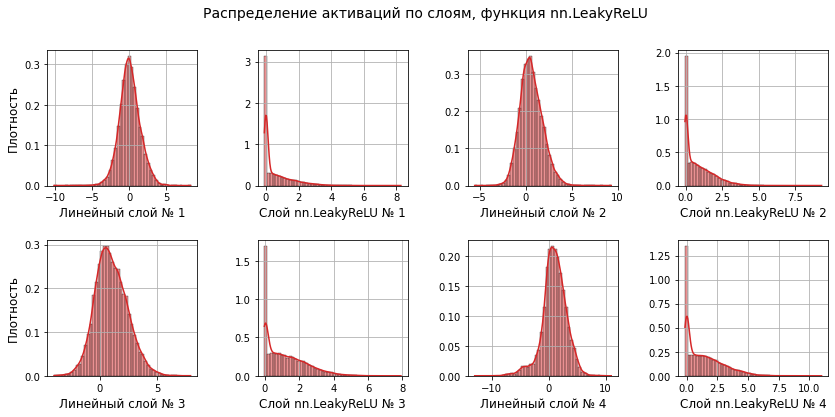

Hardshrink Cross Entropy loss : 0.0028


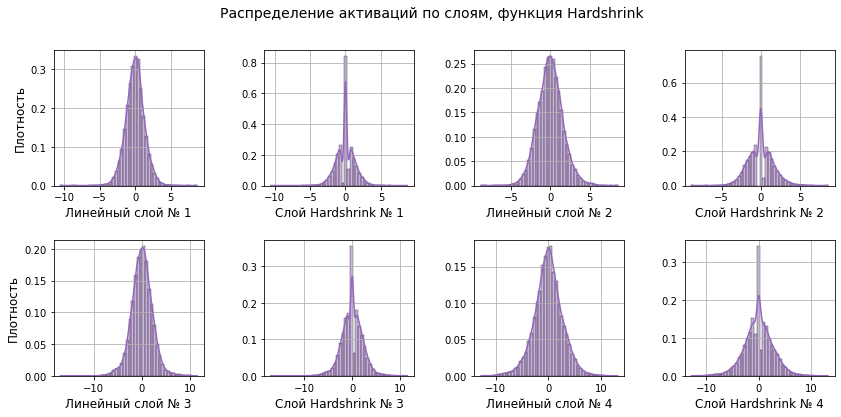

GELU Cross Entropy loss : 0.0021


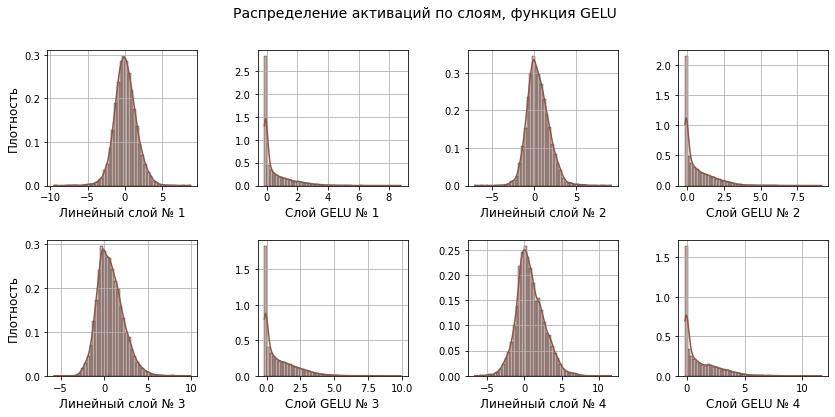

In [4]:
activation_list = [nn.LeakyReLU(), nn.Hardshrink(), nn.GELU()]
act_name_list = ['nn.LeakyReLU', 'Hardshrink', 'GELU']
title_list = ['Распределение активаций по слоям, функция ' + act for act in act_name_list]
color = ['C' + str(i) for i in range(3, 6)]
for i in range(3):
    exp_activations(train_digits, test_digits, activation_list[i], act_name_list[i], title_list[i], color[i], n_classes=10)

В данном случае вновь побеждает GELU, поэтому далее будем использовать лишь её.

### Эксперимент №2: сети разной ширины для разных датасетов

Для начала определимся с датасетом, для исследования сетей. Из sklearn toy взяты датасеты с достаточно большой выборкой:

Информация о датасетах:

    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    << Name           |  Type     ||  Instances  ||  Features  >>
    <<--------------------------------------------------------->>
    << boston         |  REG      ||  506        ||  13        >>
    << breast_cancer  |  CLF, 2   ||  569        ||  30        >>
    << diabetes       |  REG      ||  442        ||  10        >>
    << digits         |  CLF, 10  ||  1797       ||  64        >>
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
Имеем две задачи регрессии и две - классификации. 

Будем обучать сети глубины 8 постоянной ширины. Будем варировать ширину и следить за изменением распределения активаций на линейном слое для разных данных.



Сеть ширины 20 : MSE loss =  0.0036
Сеть ширины 40 : MSE loss =  0.0021
Сеть ширины 80 : MSE loss =  0.0024
Сеть ширины 160 : MSE loss =  0.0017


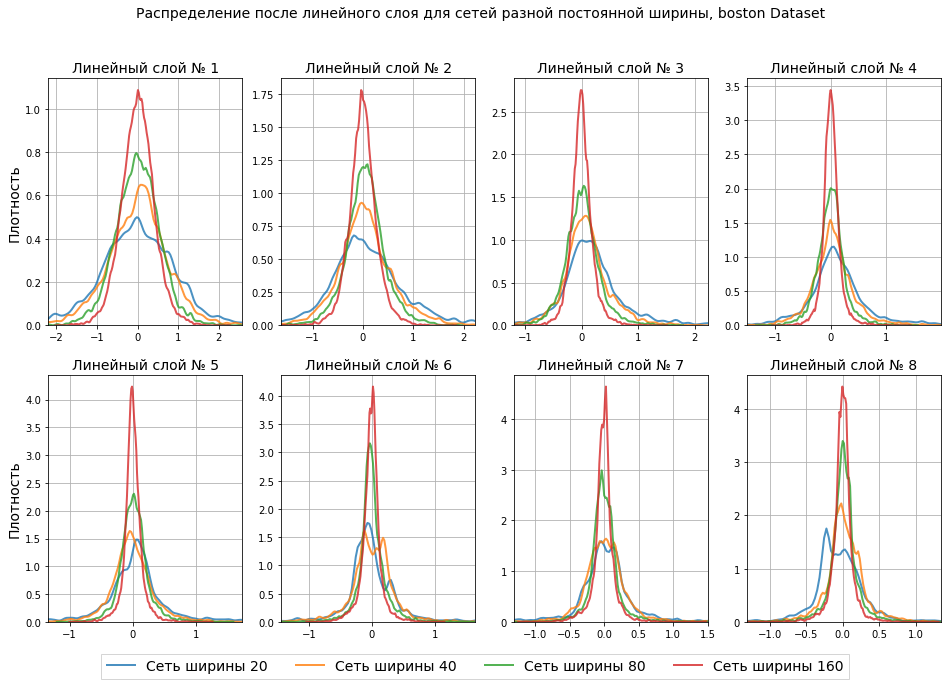

Сеть ширины 20 : MSE loss =  0.0062
Сеть ширины 40 : MSE loss =  0.0055
Сеть ширины 80 : MSE loss =  0.0059
Сеть ширины 160 : MSE loss =  0.0058


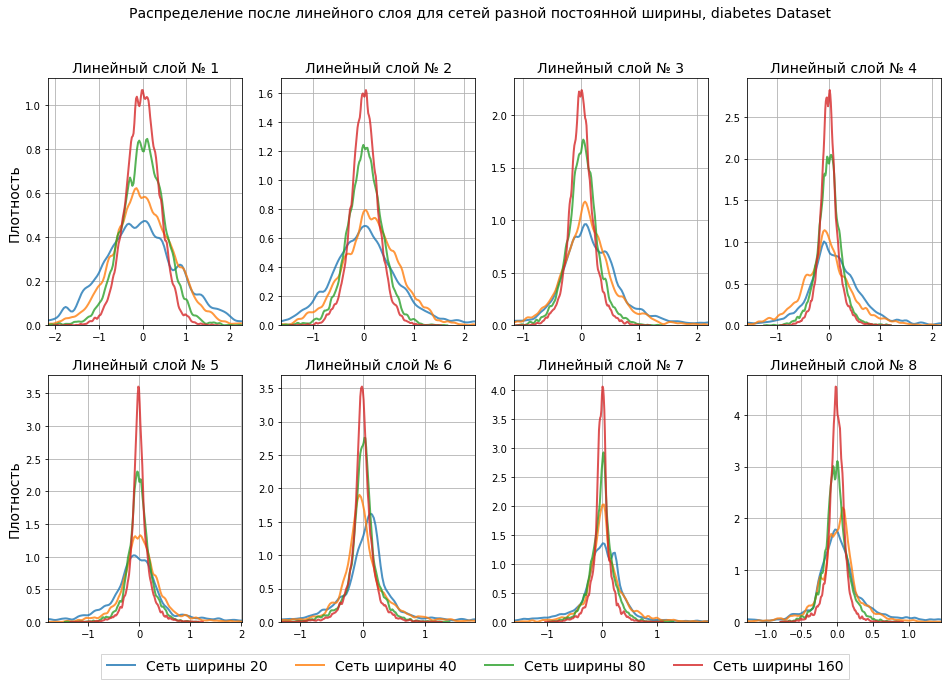

Сеть ширины 20 : Cross Entropy loss =  0.0008
Сеть ширины 40 : Cross Entropy loss =  0.0003
Сеть ширины 80 : Cross Entropy loss =  0.0022
Сеть ширины 160 : Cross Entropy loss =  0.0069


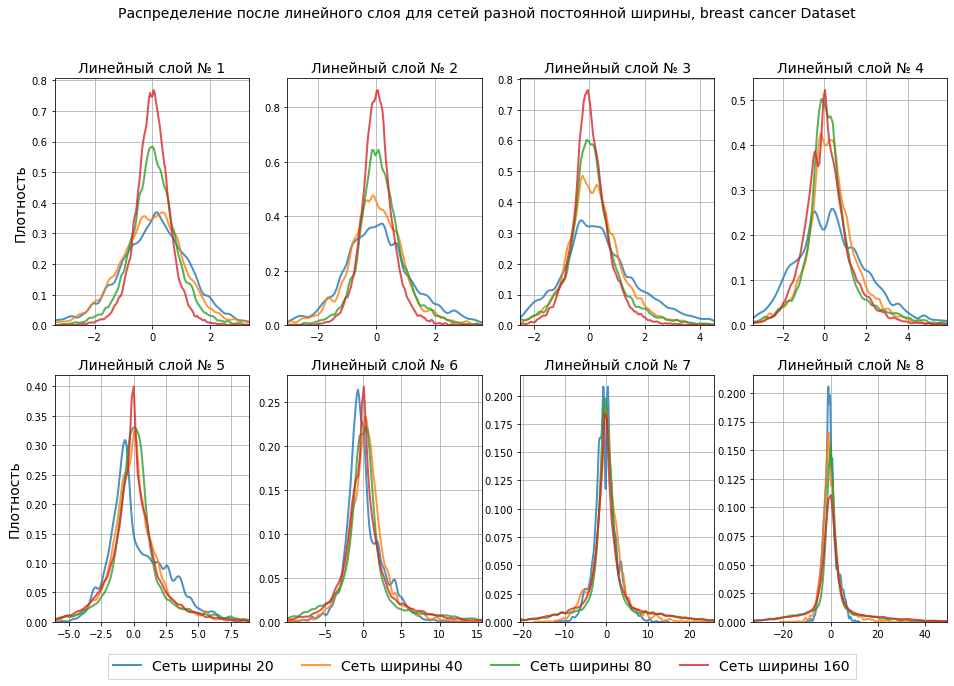

Сеть ширины 20 : Cross Entropy loss =  0.005
Сеть ширины 40 : Cross Entropy loss =  0.0027
Сеть ширины 80 : Cross Entropy loss =  0.0033
Сеть ширины 160 : Cross Entropy loss =  0.0019


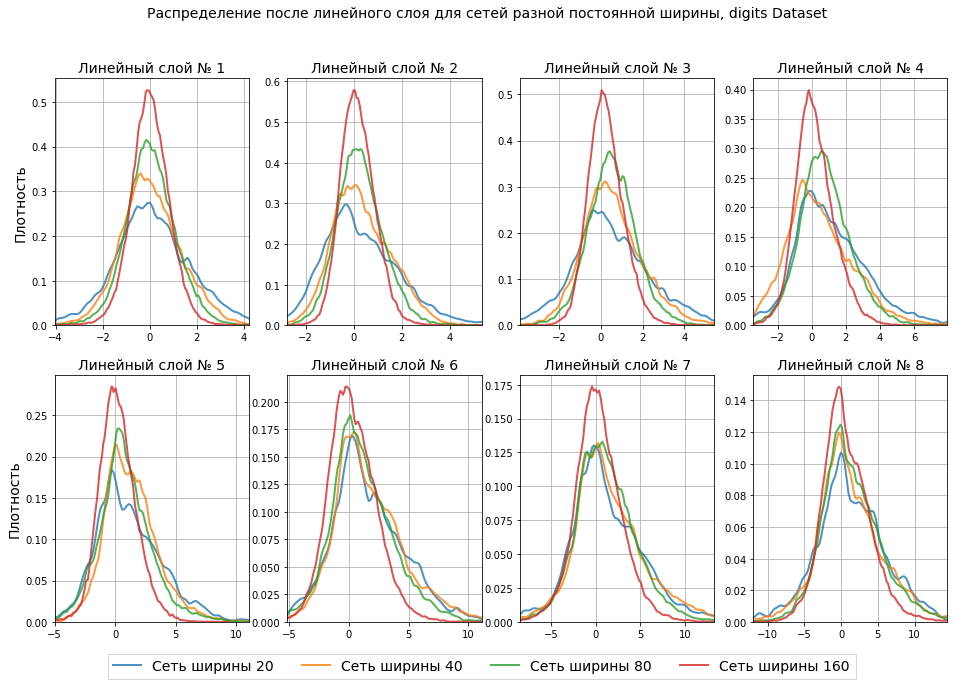

In [5]:
width_list = [20, 40, 80, 160]
model_strings = ['Сеть ширины {:}'.format(width) for width in width_list]

exp_s.exp_FFN(train_boston, test_boston,  width=width_list, mode='linear',
              title='Распределение после линейного слоя для сетей разной постоянной ширины, boston Dataset',
             model_strings=model_strings, n_models=4)

exp_s.exp_FFN(train_diabetes, test_diabetes,  width=width_list, mode='linear',
              title='Распределение после линейного слоя для сетей разной постоянной ширины, diabetes Dataset',
             model_strings=model_strings, n_models=4)

exp_s.exp_FFN(train_breast_cancer, test_breast_cancer,  width=width_list, mode='linear',
              title='Распределение после линейного слоя для сетей разной постоянной ширины, breast cancer Dataset',
             model_strings=model_strings, n_models=4, n_classes=2)

exp_s.exp_FFN(train_digits, test_digits,  width=width_list, mode='linear',
              title='Распределение после линейного слоя для сетей разной постоянной ширины, digits Dataset',
             model_strings=model_strings, n_models=4, n_classes=10)


Распределение для первых двух датасетов (boston и diabetes) почти одинаковые: у широких сетей дисперсия меньше, что вполне может объясняться тем, что большая часть весов нам и не нужна. 

Отметим, что для ширины сети x, между внутринними слоями модель будет иметь $7 x^2$ обучаемых параметров. Поэтому большая ширина в простых задачах - точно избыточна. Также заметим, что распределение на последних слоях соответствует распределению откликов.

Для задач классификации получен другой результат. Он объясняется тем, что распределение самих откликов связано с распределением активаций намного сложнее. Dataset digits намного больше других, поэтому для него графики разных сетей похожи. 

Возьмём далее в рассмотрение сложные данные digits и типовой датасет boston.

Проведём ещё один эксперимент с шириной: рассмотрим модели с примерно одинаковым числом параметров, но с разной архитектурой:
ширина первой постоянна, второй возрастает, третьей убывает.

Обычная сеть : Cross Entropy loss =  0.0017
bottle neck : Cross Entropy loss =  0.0024
reverse bottle neck : Cross Entropy loss =  0.0044


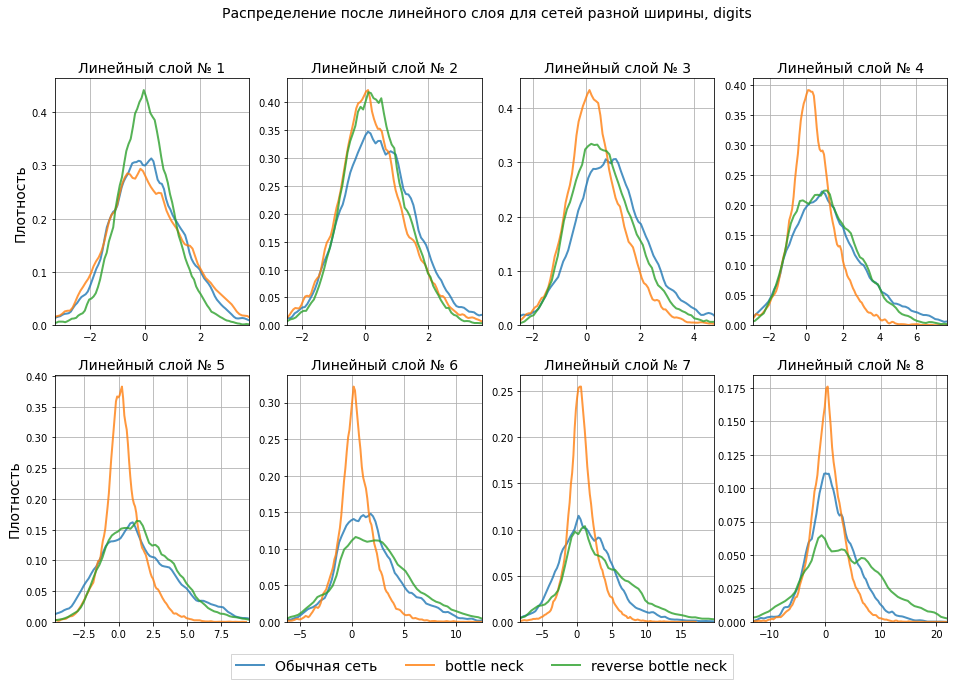

In [6]:
width_list = [
    (np.ones(8) * 40).astype(int), np.arange(20, 101, 10).astype(int), np.array(np.arange(20, 101, 10)[::-1]).astype(int)
]
model_strings = ['Обычная сеть', 'bottle neck', 'reverse bottle neck']
exp_s.exp_FFN(train_digits, test_digits,  width=width_list, mode='linear',
              title='Распределение после линейного слоя для сетей разной ширины, digits',
             model_strings=model_strings, n_models=3, n_classes=10)

### Эксперимент №3: влияние BatchNorm

Рассмотрим распределения для сетей глубины 8, ширины 64. 

Графики построим для сети без BN, сети с двумя слоями BN, четырьмя и восьмью.

Без BN : MSE loss =  0.0019
BN после 2 и 6 слоя : MSE loss =  0.0147
BN после нечётного слоя : MSE loss =  0.0167
BN после каждого слоя : MSE loss =  0.0247


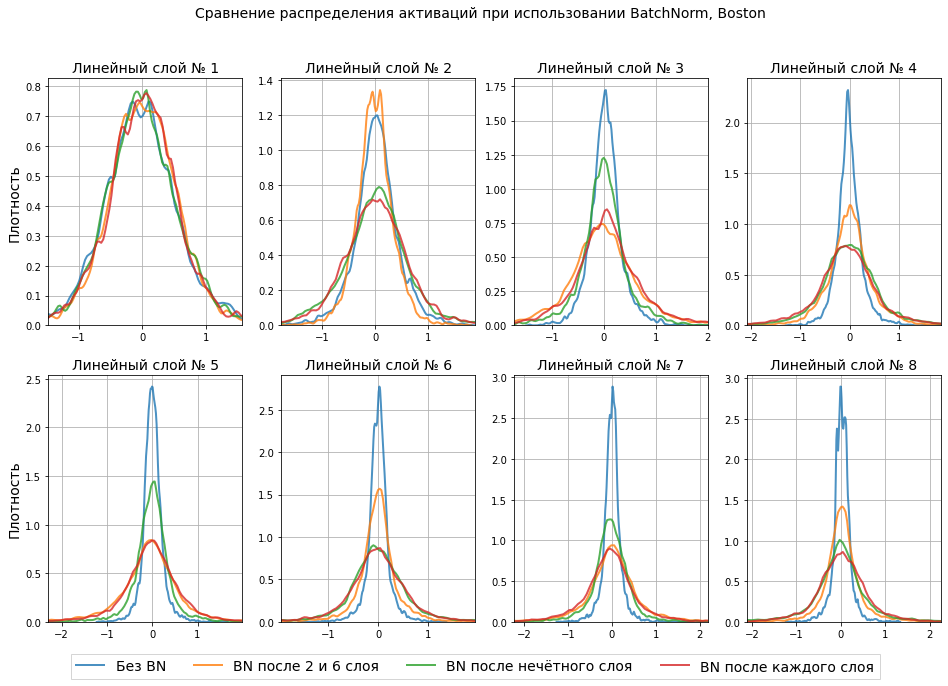

In [7]:
BN_list = [np.zeros(8), (np.arange(8) % 2 == 1).astype(int), 1 - np.arange(8) % 2, np.ones(8)]
model_strings = ['Без BN', 'BN после 2 и 6 слоя', 'BN после нечётного слоя',  'BN после каждого слоя']
title = 'Сравнение распределения активаций при использовании BatchNorm, Boston'
exp_FFN(train_boston, test_boston, title, model_strings, n_models=4, mode='linear', BN_list=BN_list, width=64)

Без BN : Cross Entropy loss =  0.0018
BN после 2 и 6 слоя : Cross Entropy loss =  0.0023
BN после нечётного слоя : Cross Entropy loss =  0.0018
BN после каждого слоя : Cross Entropy loss =  0.0031


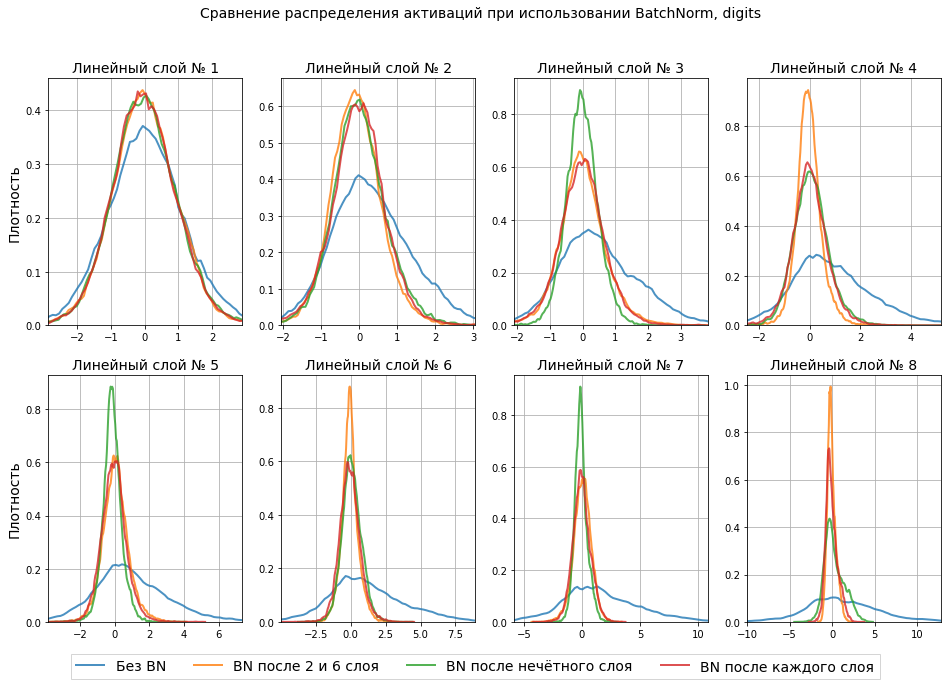

In [8]:
title = 'Сравнение распределения активаций при использовании BatchNorm, digits'
exp_FFN(train_digits, test_digits, title, model_strings, n_models=4, mode='linear', BN_list=BN_list, width=64, n_classes=10)

Получен интересный результат: 

BN в задаче регрессии привёл к повышению дисперсии, а в задаче классификации - наоборот.

На симметрию BN влияет положительно: при его использовании среднее почти не сдвигается. Причём лучше использовать относительно немного слоёв, чем вставлять BN всюду, куда можно.

### Эксперимент №4: влияние Dropout

Рассмотрим распределения для всё тех же сетей глубины 8, ширины 64. 

Графики построим для сети без DO, с DO после нечётных слоёв (p=0.25), с DO после нечётных слоёв (p=0.5), 
с DO после всех слоёв (p=0.25)

Без DO : MSE loss =  0.0021
DO после нечётного слоя (p=0.25) : MSE loss =  0.0036
DO после нечётного слоя (p=0.5) : MSE loss =  0.0026
DO после каждого слоя : MSE loss =  0.0077


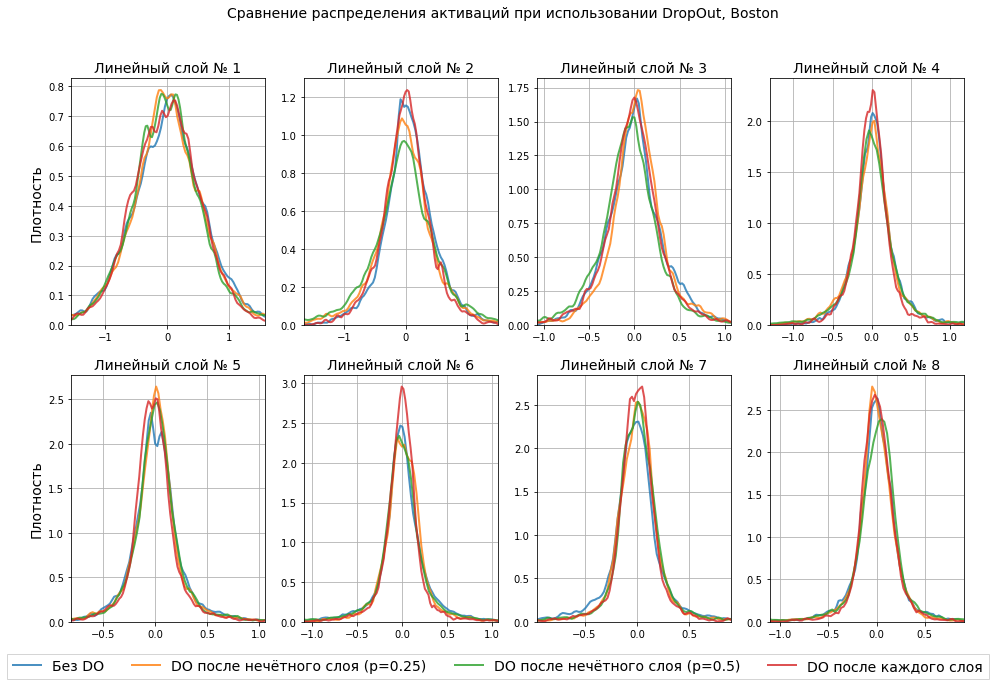

In [9]:
DO_list = [np.zeros(8), (1 - np.arange(8) % 2) * 0.25, (1 - np.arange(8) % 2) * 0.5, np.ones(8) * 0.25]
model_strings = ['Без DO', 'DO после нечётного слоя (p=0.25)' , 'DO после нечётного слоя (p=0.5)', 'DO после каждого слоя']
title = 'Сравнение распределения активаций при использовании DropOut, Boston'
exp_FFN(train_boston, test_boston, title, model_strings, n_models=4, mode='linear', DO_list=DO_list, width=64)

Без DO : Cross Entropy loss =  0.0025
DO после нечётного слоя (p=0.25) : Cross Entropy loss =  0.0035
DO после нечётного слоя (p=0.5) : Cross Entropy loss =  0.0104
DO после каждого слоя : Cross Entropy loss =  0.0077


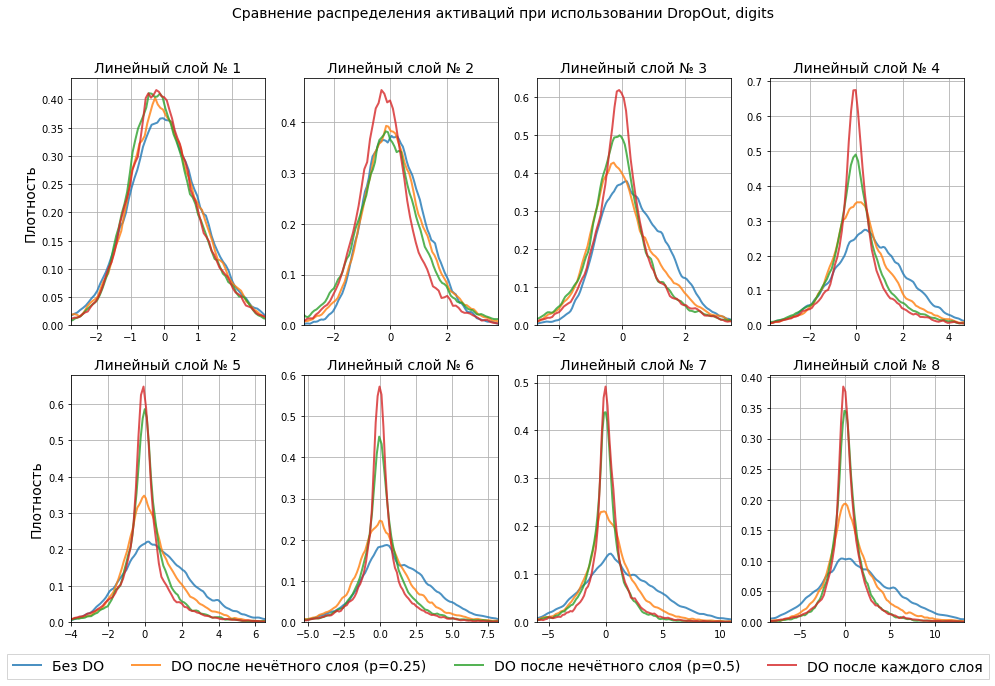

In [10]:
title = 'Сравнение распределения активаций при использовании DropOut, digits'
exp_FFN(train_digits, test_digits, title, model_strings, n_models=4, mode='linear', DO_list=DO_list, width=64, n_classes=10)

Результаты для разных данных снова разные:

Для простой задачи DropOut принёс незначительные изменения в распределение активаций.

Для сложной задачи DropOut после каждого слоя значительно сократил дисперсию, но ценой качества. Отметим, что параметр $p$ значительным образом влияет на распределение в сети.

Можно заключить, что для простых моделей DropOut излишен, а для сложных хорошо борется с ростом дисперсии и сохраняет распределение активаций.

### Эксперимент №5: влияние инициализации

Рассмотрим пять инициализаций:

Xavier и kaiming: Uniform и Normal, а также равномерное распределение на отрезке \[0,0.01\]

Xavier uniform : MSE loss =  0.0018
Kaiming uniform : MSE loss =  0.0013
Xavier normal : MSE loss =  0.0017
Kaiming normal : MSE loss =  0.002
Uniform [0, 0.01] : MSE loss =  0.0066


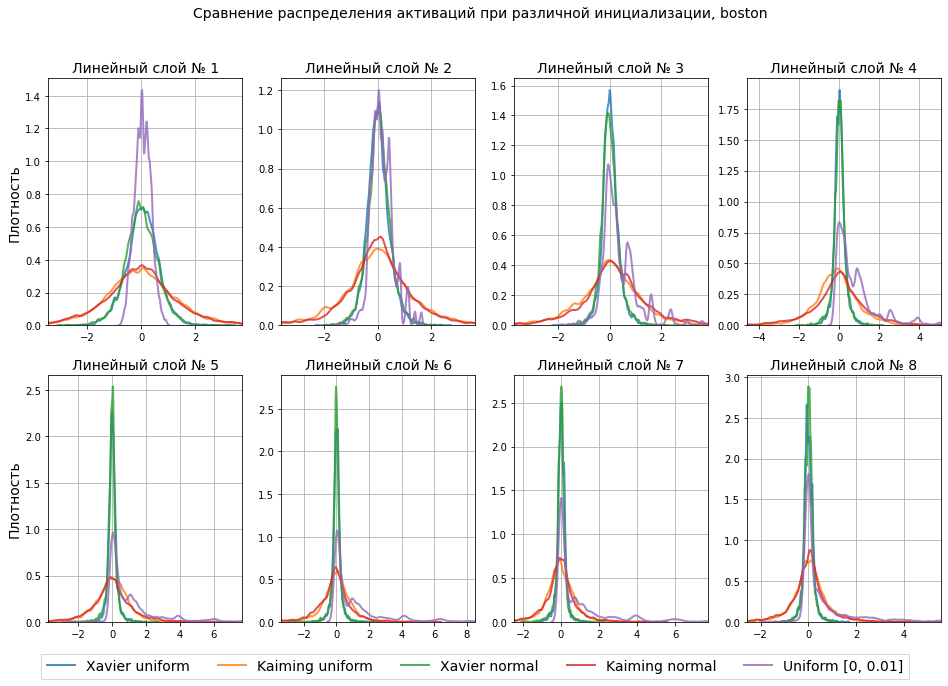

In [11]:
inits = [nn.init.xavier_uniform_, nn.init.kaiming_uniform_, nn.init.xavier_normal_, 
         nn.init.kaiming_normal_, nn.init.uniform_]
kwargs_list = [{}, {}, {}, {}, {'a':0, 'b':0.01}]
init_lists = [[(init_, kwargs_list[i])] * (8 + 1) for i ,init_ in enumerate(inits)]
title = 'Сравнение распределения активаций при различной инициализации, boston'
model_strings =  ['Xavier uniform', 'Kaiming uniform', 'Xavier normal', 'Kaiming normal', 'Uniform [0, 0.01]']
exp_FFN(train_boston, test_boston, title, model_strings, n_models=5, mode='linear', init_lists=init_lists, width=64)

Xavier uniform : Cross Entropy loss =  0.0034
Kaiming uniform : Cross Entropy loss =  0.0041
Xavier normal : Cross Entropy loss =  0.0022
Kaiming normal : Cross Entropy loss =  0.0048
Uniform [0, 0.01] : Cross Entropy loss =  0.0164


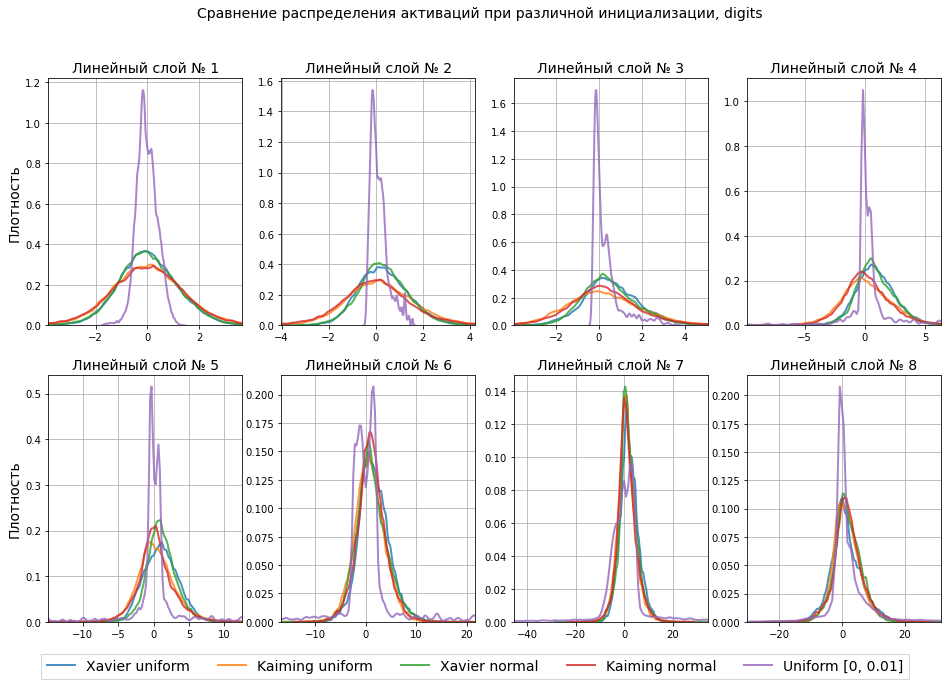

In [12]:
title = 'Сравнение распределения активаций при различной инициализации, digits'
model_strings =  ['Xavier uniform', 'Kaiming uniform', 'Xavier normal', 'Kaiming normal', 'Uniform [0, 0.01]']
exp_FFN(train_digits, test_digits, title, model_strings, n_models=5, mode='linear', 
        init_lists=init_lists, n_classes=10, width=64)

В случае boston инициализация имела значительный эффект: с одной стороны Xavier сильно снижает дисперсию с ростом номера слоя, с другой Kaiming имеет бОльшую дисперсию. Равномерное распределение имеет большой хвост и является плохой инциализацией.

В случае сложной задачи - опять наоборот, равномерное распределение имеет неприятный хвост, но в целом похоже на нормальное.
Все остальные инициализации значительно отстают по качеству сохраниния распределения.

### Эксперимент №6: влияние skip-connect

Поясню обозначения для следующего эксперимента:

No skip - не используется skip-connect.

skip features - после каждого слоя к выходам конкатенируем исходные признаки.

simple skip - прокидываем активации с прошлого слоя.

double skip - прокидываем активации с двух слоёв назад.

No skip : MSE loss =  0.0018
skip features : MSE loss =  0.0014
double skip : MSE loss =  0.0029
simple skip : MSE loss =  0.0024


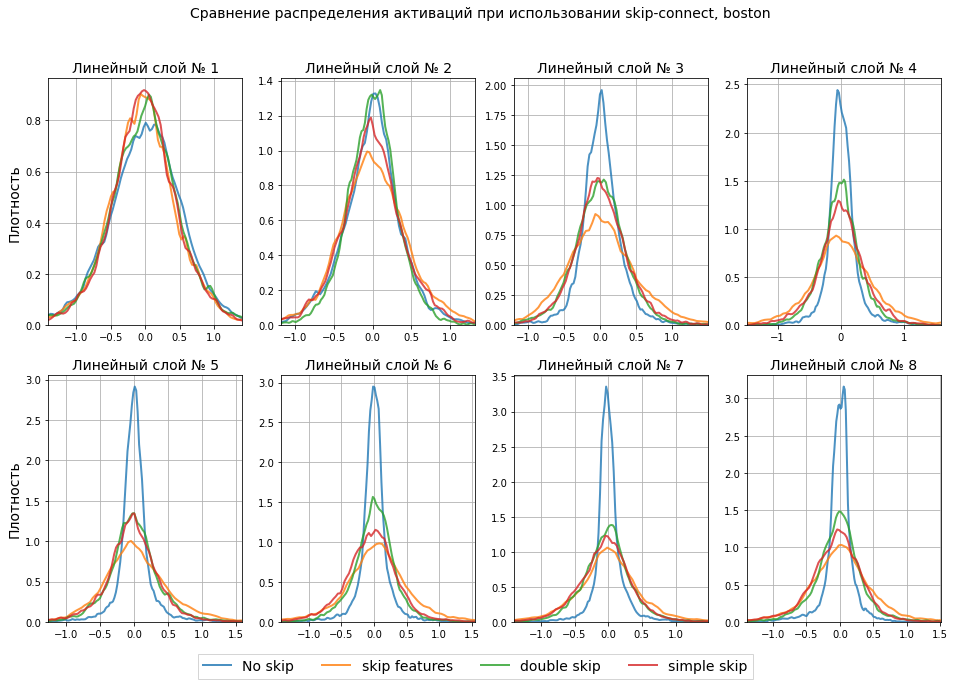

In [13]:
skip_list = [np.zeros(9, dtype= int)-1, np.zeros(9, dtype= int), np.arange(9, dtype= int)-2, np.arange(9, dtype= int)-1]
title = 'Сравнение распределения активаций при использовании skip-connect, boston'
model_strings =  ['No skip', 'skip features', 'double skip', 'simple skip']
exp_FFN(train_boston, test_boston, title , model_strings, 
        n_models=4, mode='linear', width=64, skip_list=skip_list)

No skip : Cross Entropy loss =  0.0016
skip features : Cross Entropy loss =  0.0009
double skip : Cross Entropy loss =  0.0016
simple skip : Cross Entropy loss =  0.0017


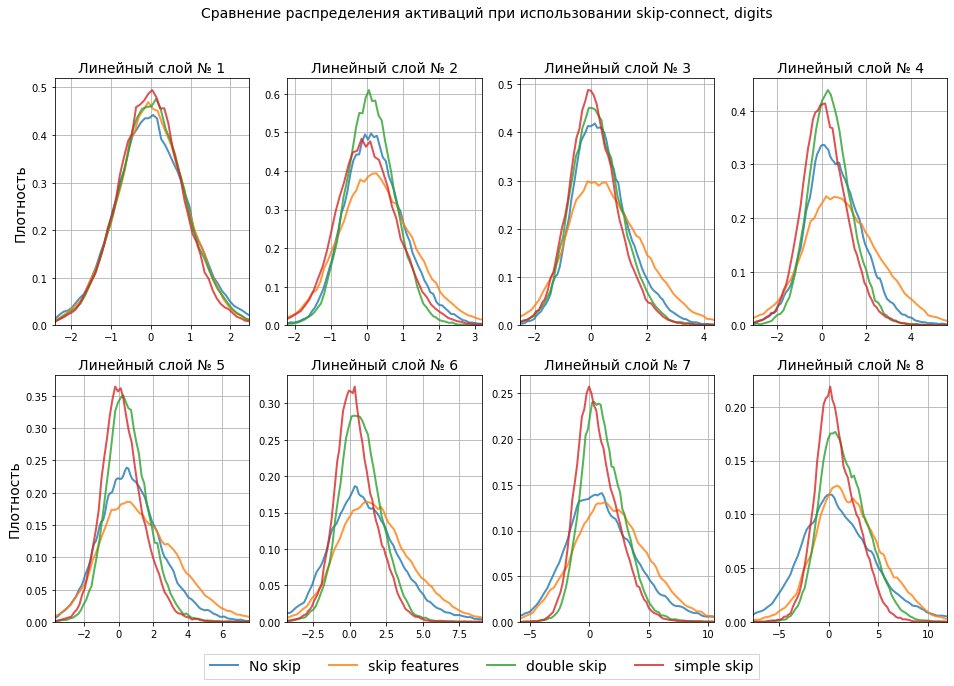

In [14]:
title = 'Сравнение распределения активаций при использовании skip-connect, digits'
exp_FFN(train_digits, test_digits, title, model_strings, 
        n_models=4, mode='linear', width=64, skip_list=skip_list, n_classes=10)

Для прсотой задачи skip-connect сохранил, но не улучшил распределение. 

В случае сложной, double skip отлично сохранил вид распределения, хотя дисперсия выросла.

### Эксперимент №6: clipping активаций

Под клиппингом активаций можно понимать ограничение функции активации сверху.

Пример такой известной функции - ReLU6

$$
\text{ReLU6}(x) = \begin{cases}
    \text{ReLU}(x) & \text{if } x < 6 \\ % & is your "\tab"-like command (it's a tab alignment character)
    6 & \text{otherwise.}
\end{cases}
$$

Аналогично для $\text{GELU}(\theta)$

$$
\text{GELU}(\theta)(x) = \begin{cases}
    \text{GELU}(x) & \text{if } x < \theta \\ % & is your "\tab"-like command (it's a tab alignment character)
    \theta & \text{otherwise.}
\end{cases}
$$

Для задачи регрессии выставим пороги 0.1, 0.3, 0.6, 1

Для задачи классификации: 0.5, 1, 3, 5

GELU(0.1) : MSE loss =  0.002
GELU(0.3) : MSE loss =  0.0043
GELU(0.6) : MSE loss =  0.0039
GELU(1.0) : MSE loss =  0.0049


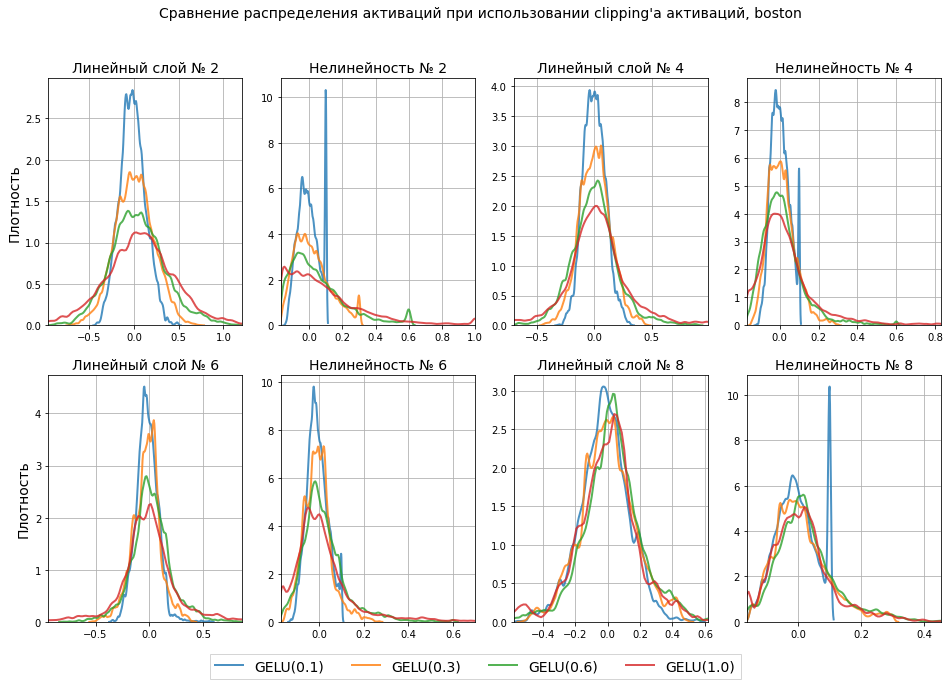

In [15]:
clip_list = [0.1, 0.3, 0.6, 1]
model_strings =  ['GELU({:.1f})'.format(x) for x in clip_list]
title = 'Сравнение распределения активаций при использовании clipping\'а активаций, boston'
exp_FFN(train_boston, test_boston, title, model_strings, n_models=4, mode='both', width=64, clip_list=clip_list)

GELU(0.5) : Cross Entropy loss =  0.0038
GELU(1.0) : Cross Entropy loss =  0.0013
GELU(3.0) : Cross Entropy loss =  0.0018
GELU(5.0) : Cross Entropy loss =  0.0018


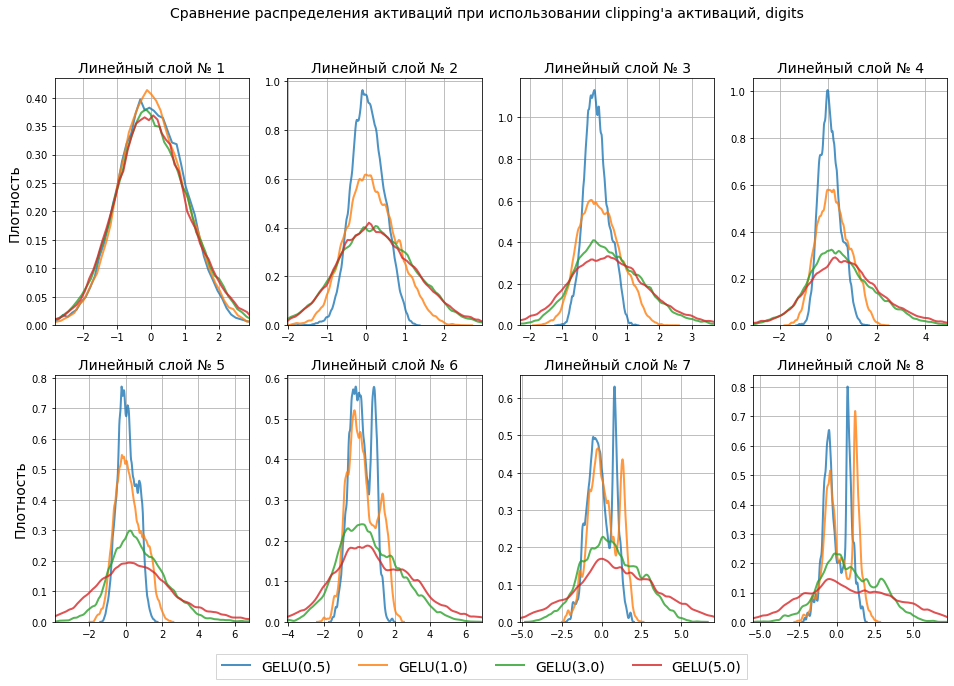

In [16]:
clip_list = [0.5, 1, 3, 5]
model_strings =  ['GELU({:.1f})'.format(x) for x in clip_list]
title = 'Сравнение распределения активаций при использовании clipping\'а активаций, digits'
exp_FFN(train_digits, test_digits, title, model_strings, n_models=4, mode='linear', width=64, clip_list=clip_list, n_classes=10)

Заметно, что обрезание всюду сокращает дисперсию, но значительно меняет вид распределения.